### 3.2. 线性回归的从零开始实现

In [1]:
%matplotlib inline
import random
import torch
from d2l import torch as d2l

/home/mkid/anaconda3/envs/pytorch/lib/python3.6/site-packages/torch/cuda/__init__.py:80: UserWarning: CUDA initialization: The NVIDIA driver on your system is too old (found version 10010). Please update your GPU driver by downloading and installing a new version from the URL: http://www.nvidia.com/Download/index.aspx Alternatively, go to: https://pytorch.org to install a PyTorch version that has been compiled with your version of the CUDA driver. (Triggered internally at  /opt/conda/conda-bld/pytorch_1640811748419/work/c10/cuda/CUDAFunctions.cpp:112.)
  return torch._C._cuda_getDeviceCount() > 0


#### 3.2.1 生成数据集

In [5]:
def synthetic_data(w, b, num_examples):  #@save
    """生成y=Xw+b+噪声"""
    X = torch.normal(0, 1, (num_examples, len(w)))  # 返回一个正态分布(0, 1)
    y = torch.matmul(X, w) + b  # 两个向量的矩阵乘法
    y += torch.normal(0, 0.01, y.shape) # 噪声
    return X, y.reshape((-1, 1))

true_w = torch.tensor([2, -3.4])    # 旨在产生 y = w1x1 + w2x2 + b + 噪声的函数
true_b = 4.2
features, labels = synthetic_data(true_w, true_b, 1000)
print(f'x = {features.shape}, y = {labels.shape}')

x = torch.Size([1000, 2]), y = torch.Size([1000, 1])


In [6]:
print('features:', features[0],'\nlabel:', labels[0])

features: tensor([0.9593, 0.8987]) 
label: tensor([3.0700])


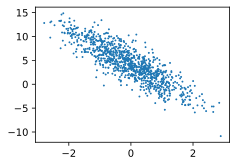

In [11]:
d2l.set_figsize()
d2l.plt.scatter(features[:, 1].detach().numpy(), labels.detach().numpy(), 1)

#### 3.2.2. 读取数据集

In [23]:
def data_iter(batch_size, features, labels):
    num_examples = len(features)
    indices = list(range(num_examples))
    # 这些样本是随机读取的，没有特定的顺序
    random.shuffle(indices)
    for i in range(0, num_examples, batch_size):
        batch_indices = torch.tensor(
            indices[i: min(i + batch_size, num_examples)])
        print(i, end=' ')
        yield features[batch_indices], labels[batch_indices]    # 优化内存，每执行一次函数，才返回一次数据

In [25]:
batch_size = 10

for X, y in data_iter(batch_size, features, labels):
    print(X, '\n', y)
    break

0 tensor([[-0.4195, -1.7300],
        [-1.8081,  1.0682],
        [ 0.7984, -1.7436],
        [-0.8902, -0.7666],
        [ 1.4614,  1.5384],
        [ 1.5541, -0.1970],
        [-0.6992, -1.3317],
        [-0.8441, -0.3822],
        [-0.2822,  0.4812],
        [-0.6569, -0.6955]]) 
 tensor([[ 9.2481],
        [-3.0520],
        [11.7180],
        [ 5.0148],
        [ 1.8911],
        [ 7.9866],
        [ 7.3261],
        [ 3.7992],
        [ 2.0080],
        [ 5.2620]])


#### 3.2.3. 初始化模型参数

In [26]:
w = torch.normal(0, 0.01, size=(2,1), requires_grad=True)
b = torch.zeros(1, requires_grad=True)
print(f'w = {w}, b = {b}')

w = tensor([[-0.0019],
        [-0.0041]], requires_grad=True), b = tensor([0.], requires_grad=True)


#### 3.2.4. 定义模型

In [27]:
def linreg(X, w, b):  #@save，线性回归模型
    """线性回归模型"""
    return torch.matmul(X, w) + b

#### 3.2.5. 定义损失函数

In [28]:
def squared_loss(y_hat, y):  #@save
    """均方损失"""
    return (y_hat - y.reshape(y_hat.shape)) ** 2 / 2    # y是真实标签

#### 3.2.6. 定义优化算法

In [ ]:
def sgd(params, lr, batch_size):  #@save
    """小批量随机梯度下降"""
    with torch.no_grad():
        for param in params:
            param -= lr * param.grad / batch_size
            param.grad.zero_()